# 1. Introduction  
Airbnb has been disrupting short-term house and apartment rentals market since its inception in 2008.  
To help people price it right in Lisbon, Portugal I am running an analysis from 2021 data available in http://insideairbnb.com/get-the-data.html  
I was inspired by Allan Bruno's great work about Rio de Janeiro, Brazil found here: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb  
Also, all of this wouldn't be possible without the amazing and fantastic job made by https://scikit-learn.org/stable/  
First, I begin importing what is necessary for the project:

In [193]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pathlib as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

# 2. Initial Data Analysis  
Right now I import our dataframes into one file and display its content and info:

In [194]:
path = pl.Path (f"archive")
df_list = [] 

for file in path.iterdir():
    df_list.append(pd.read_csv(file))

dfraw = pd.concat(df_list, ignore_index=True)

In [195]:
dfraw.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76716 entries, 0 to 76715
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            76716 non-null  int64  
 1   listing_url                                   76716 non-null  object 
 2   scrape_id                                     76716 non-null  int64  
 3   last_scraped                                  76716 non-null  object 
 4   name                                          76679 non-null  object 
 5   description                                   76640 non-null  object 
 6   neighborhood_overview                         50239 non-null  object 
 7   picture_url                                   76716 non-null  object 
 8   host_id                                       76716 non-null  int64  
 9   host_url                                      76716 non-null 

I am dropping all columns regarding:  
- IDs, URLs, dates, licenses, availabilities, names and descriptions, except for bathrooms text;  
- host data, except for if it's a superhost and its total listings count at the end, since verified status comes with the reviews;  
- locations, except for latitude and longitude;  
- property type, since it's already embedded in room type;  
- nights quantities, except for minimum nights.

In [196]:
dfraw.drop (dfraw.iloc [:, 0 : 29], axis = 1, inplace = True) # until latitude
dfraw.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76716 entries, 0 to 76715
Data columns (total 45 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   latitude                                      76716 non-null  float64
 1   longitude                                     76716 non-null  float64
 2   property_type                                 76716 non-null  object 
 3   room_type                                     76716 non-null  object 
 4   accommodates                                  76716 non-null  int64  
 5   bathrooms                                     0 non-null      float64
 6   bathrooms_text                                76619 non-null  object 
 7   bedrooms                                      72744 non-null  float64
 8   beds                                          75530 non-null  float64
 9   amenities                                     76716 non-null 

In [197]:
dfraw.drop (dfraw.iloc [:, 11 :], axis = 1, inplace = True)
dfraw.info ()
dfraw.drop (dfraw.iloc [:, 2 : 4], axis = 1, inplace = True) # just lat long
#dfraw.drop (dfraw.iloc [:, 0 : 3], axis = 1, inplace = True)  # just room_type
#dfraw.drop (dfraw.iloc [:, 0 : 4], axis = 1, inplace = True)  # no room_type and no latlong
dfraw.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76716 entries, 0 to 76715
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        76716 non-null  float64
 1   longitude       76716 non-null  float64
 2   property_type   76716 non-null  object 
 3   room_type       76716 non-null  object 
 4   accommodates    76716 non-null  int64  
 5   bathrooms       0 non-null      float64
 6   bathrooms_text  76619 non-null  object 
 7   bedrooms        72744 non-null  float64
 8   beds            75530 non-null  float64
 9   amenities       76716 non-null  object 
 10  price           76716 non-null  object 
dtypes: float64(5), int64(1), object(5)
memory usage: 6.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76716 entries, 0 to 76715
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        76716 non-null  float64
 

Let us see how it's all going and at the same time if there's a lot of missing values:

In [198]:
dfraw.isnull ().sum ()

latitude              0
longitude             0
accommodates          0
bathrooms         76716
bathrooms_text       97
bedrooms           3972
beds               1186
amenities             0
price                 0
dtype: int64

Since there are too much missing values among review columns and I can't afford to lose 17% of everything, I'm going to drop those as well.

At this moment I have to get the numbers of bathrooms out from bathrooms text and only then drop the few rows containing missing values.

In [199]:
dfraw['bathrooms'] = dfraw['bathrooms_text'].str.extract("(\d*\.?\d+)", expand=False)
dfraw['bathrooms'] = np.where(dfraw['bathrooms_text'].str.contains("half", case=False, na=False), 0.5, dfraw['bathrooms'])
dfraw = dfraw.dropna ()

# 3. Exploratory Data Analysis  
Now I copy to a new dataframe to analyse its columns and possibly remove some outliers.  
We start by checking the data types:

In [200]:
df = dfraw.drop ("bathrooms_text", axis = 1)
df.dtypes

latitude        float64
longitude       float64
accommodates      int64
bathrooms        object
bedrooms        float64
beds            float64
amenities        object
price            object
dtype: object

Ok, price and bathrooms should be numbers, and the ones that are properly numbers can still be converted from 64 bits to 32 bits to save memory, processing and, therefore, time. So, I am doing exactly that:

In [201]:
df ["price"] = df ["price"].str.replace ("$", "", regex = False)
df ["price"] = df ["price"].str.replace (",", "", regex = False)
df ["price"] = df ["price"].astype (np.float32, copy = False)
df ["price"] = df ["price"].astype (np.int32, copy = False)
df ["accommodates"] = df ["accommodates"].astype (np.int32, copy = False)
df ["bedrooms"] = df ["bedrooms"].astype (np.int32, copy = False)
df ["beds"] = df ["beds"].astype (np.int32, copy = False)
df ["bathrooms"] = df ["bathrooms"].astype (np.float32, copy = False)
df ["latitude"] = df ["latitude"].astype (np.float32, copy = False)
df ["longitude"] = df ["longitude"].astype (np.float32, copy = False)

At this time I'll create a function that statistically define outliers using interquartile range, and some graphical functions to identify which room types there are and how prices are distributed throughout the dataframe:

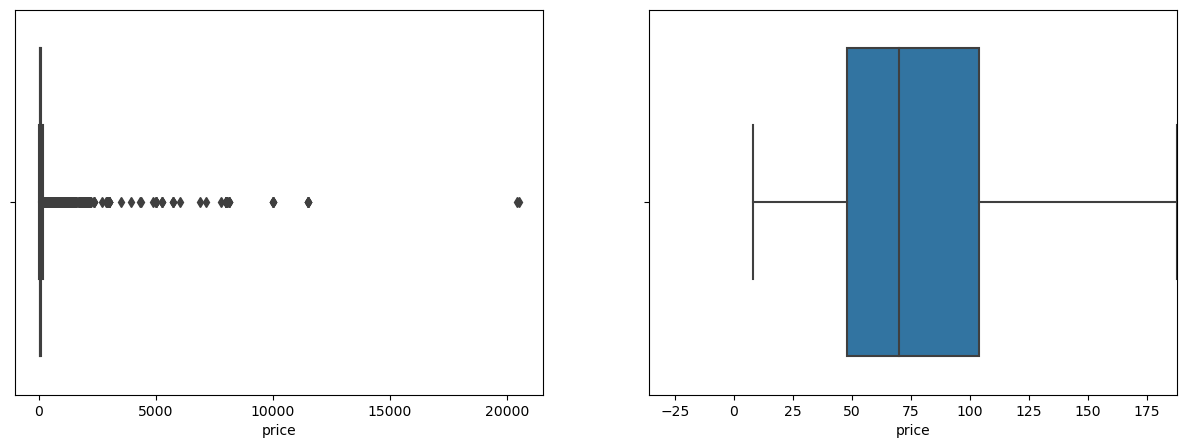

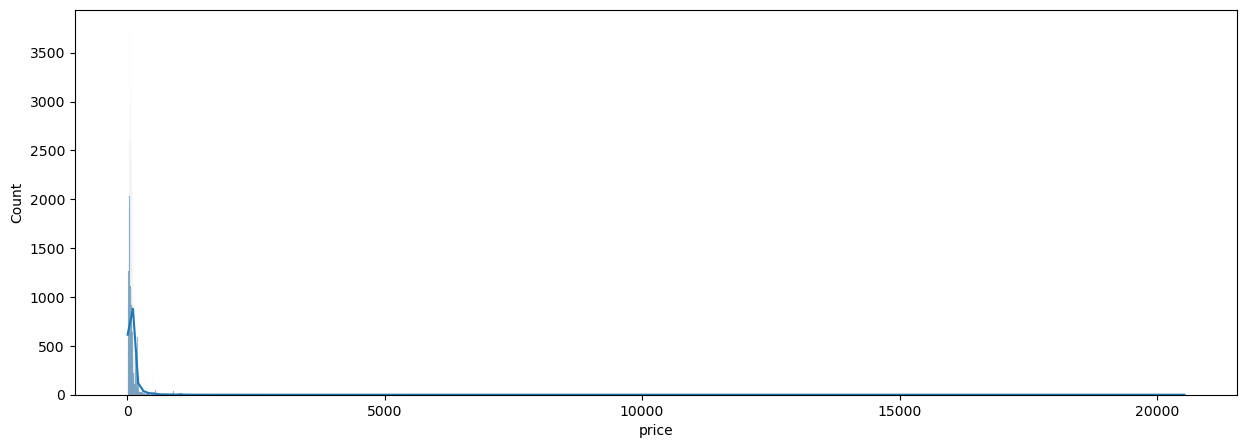

In [202]:
def outlier (col):
    q1 = col.quantile (0.25)
    q3 = col.quantile (0.75)
    iqr = q3 - q1
    lenght = 1.5
    return q1 - lenght * iqr, q3 + lenght * iqr

def box (col):
    fig, (ax1, ax2) = plt.subplots (1, 2)
    fig.set_size_inches (15, 5)
    sns.boxplot (x = col, ax = ax1)
    ax2.set_xlim (outlier (col))
    sns.boxplot (x = col, ax = ax2)

def hist (col):
    plt.figure (figsize = (15,5))
    sns.histplot (col, kde = True)

def bar (col):
    plt.figure (figsize = (15,5))
    ax = sns.barplot (x = col.value_counts ().index, y = col.value_counts ())
    if col.dtypes != "object":
        ax.set_xlim (outlier (col))
        
box (df ["price"])
hist (df ["price"])

As we can see, there is a lot of price anomalies we'd rather remove; and almost 75% of the room types consist of entire homes or apt, so we can get together private, shared and hotel rooms into just one category.

6106 rows removed
65503 total rows and 8 total columns


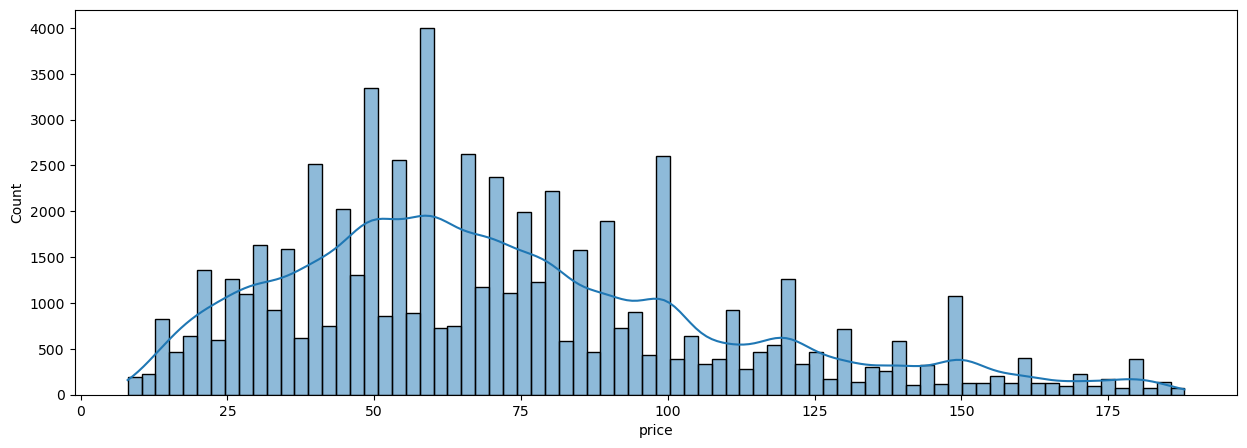

In [203]:
def remove (ds, col):
    before = ds.shape [0]
    low, up = outlier (ds [col])
    ds = ds.loc [(ds [col] >= low) & (ds [col] <= up), :]
    return ds, before - ds.shape [0]
df, removed = remove (df, "price")

"""
aux = df ["room_type"].value_counts ()
for kind in aux.index:
    if aux [kind] < 15000:
        df.loc [df ["room_type"] == kind, "room_type"] = "Rooms"
"""
        
print (f"{removed} rows removed")
hist (df ["price"])
print (f"{df.shape [0]} total rows and {df.shape [1]} total columns")

Almost 10% of the data were removed and I personally think that's enough discrepancies out of the equation.  
I decided that all those amenities will be counted instead of compared with each other individually.  
So why not take a look at how the dataframe appears currently and where those rentals are spread around Lisbon?

In [204]:
df ["qty"] = df ["amenities"].str.split (",").apply (len)
df ["qty"] = df ["qty"].astype (np.int32, copy = False)
dfenc = df.drop ("amenities", axis = 1)
display (dfenc)
#px.density_mapbox (df, lat = "latitude", lon = "longitude", z = "price", radius = 2.5, center = {"lat": df.latitude.mean (), "lon": df.longitude.mean ()}, zoom = 10, mapbox_style = "stamen-terrain").show ()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,qty
0,38.697498,-9.197680,4,1.0,1,1,40,36
1,38.712410,-9.127060,3,1.0,1,1,50,27
2,38.710819,-9.127190,4,1.0,1,2,60,18
3,38.711559,-9.129870,4,1.0,1,1,60,26
6,38.764271,-9.153010,6,2.0,1,3,40,10
...,...,...,...,...,...,...,...,...
76708,38.709438,-9.151200,2,1.0,1,1,68,27
76710,38.704609,-9.202180,4,1.0,2,3,58,49
76712,38.733501,-9.142750,2,1.0,1,1,31,3
76714,38.711952,-9.135315,3,1.0,1,0,80,17


# 4. Encoding and Modeling  
In a new copy of the dataframe, columns with just two kinds of values will be encoded into true or false categories, since this is better when running machine learning algorithms. Later we verify the correlation among all columns and if their types are ready for modeling:

I am making a function that will return three evaluation methods: Root mean squared error; Mean absolute error; and R² score.  
The mean errors show by how much the model is erroring, in average. And the R² score says how much percent the model is getting it right.  
After that I'll start the regression models, split the data into 80% for training and 20% for testing, and run the models to find out the best ones.

In [205]:
def evaluate (model, ytest, prediction):
    rmse = np.sqrt (mean_squared_error (ytest, prediction))
    mae = mean_absolute_error (ytest, prediction)
    r2 = r2_score (ytest, prediction)
    return f"\n-----\nModel: {model}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR2: {r2:.2%}\n-----\n"

models = {'Random Forest': RandomForestRegressor (),
          'Decision Tree': DecisionTreeRegressor (),
          'Extra Trees': ExtraTreesRegressor ()
          }

y = dfenc ["price"]
x = dfenc.drop ("price", axis = 1)
xtrain, xtest, ytrain, ytest = train_test_split (x, y)

for name, model in models.items ():
    model.fit (xtrain, ytrain)
    prediction = model.predict (xtest)
    print (evaluate (name, ytest, prediction))


-----
Model: Random Forest
RMSE: 20.62
MAE: 14.03
R2: 69.87%
-----


-----
Model: Decision Tree
RMSE: 25.15
MAE: 14.97
R2: 55.15%
-----


-----
Model: Extra Trees
RMSE: 20.98
MAE: 13.03
R2: 68.80%
-----



# 6. Conclusion  
Both models have improved, with Extra Trees being slightly better by providing circa 75% success rate and less than only 20 of average errors.  
I hope this proofs helpful for anyone trying to price Airbnb rentals right in Lisbon, Portugal.